# Select a location for the well

Let's say you work for GlavRosGosNeft, a production company. You need to decide where to drill a new well.

You are given oil samples from three regions: each has 10,000 fields where the quality of the oil and the volume of its reserves have been measured. Build a machine learning model to help you determine the region where production will yield the highest profit. Analyze the possible profits and risks using the *Bootstrap.* technique.

Steps for selecting a location:

- In the selected region, look for deposits and determine feature values for each;
- Build a model and estimate the amount of reserves;
- Select the fields with the highest estimated values. The number of fields depends on the company's budget and the cost of developing one well;
- Profit is equal to the total profit of the selected fields.

**Description of data**

Exploration data of the three regions are in the files: geo_data_0.csv, geo_data_1.csv and geo_data_2.csv.

- id - unique field identifier;
- f0, f1, f2 - three attributes of the points (it does not matter what they mean, but the attributes themselves are significant);
- product - volume of reserves in the field (thousand barrels).



**Problem conditions:**

- Only linear regression is suitable for model training (the others are not predictive enough).
- The exploration of the region involves the study of 500 points.
- The budget for field development is 10 billion rubles, the cost of drilling one well is 50 million rubles.
- The cost of one barrel of oil is 450 rubles. The volume is specified in 1000 barrels.
- Do not consider regions where the risk of losses is higher than 2.5%. The region with the highest average profit is selected from the remaining regions.

## Data loading and preparation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from collections import defaultdict

In [2]:
# constants from the condition
TOP_WELLS = 200
WELL_POINTS = 500
BOOTSTRAP_SAMPLES = 1000
BUDGET = 10e9
WELL_COST = 50e6
BARREL_PROFIT = 450
THRESHOLD = 0.025
CONFIDENCE_LEVEL = 0.95

In [3]:
# load all the data into the list
files = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
dataframes = []

for file in files:
    with open(os.path.join('/datasets/', file)) as f:
        dataframes.append(pd.read_csv(f, index_col='id'))

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

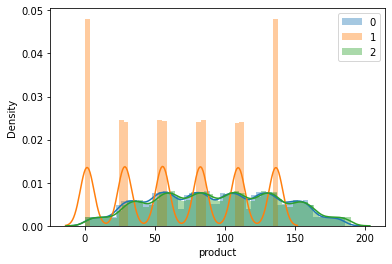

In [4]:
for i, df in enumerate(dataframes):
    sns.distplot(df['product'], label=i)
    plt.legend()

We see that the distribution is different for each well. Region 1 is characterized by pronounced peaks, while regions 0 and 2 are characterized by a more uniform distribution.

In [5]:
# divide the data into attributes and targeting
features = []
target = []

for df in dataframes:
    features.append(df.drop('product', axis=1))
    target.append(df['product'])

## Model training and validation

In [6]:
all_splits = train_test_split(
    *features, *target, test_size=0.25, random_state=42)

features_train = all_splits[0: len(features)*2: 2]
features_valid = all_splits[1: len(features)*2: 2]
target_train = all_splits[len(features)*2: len(all_splits): 2]
target_valid = all_splits[len(features)*2+1: len(all_splits): 2]


Since we use linear regression, we will check errors using RMSE

In [7]:
# write a function that calculates rmse
def rmse(true, predicted):
    return mean_squared_error(true,predicted)**0.5

In [8]:
result = {'Region':['Region 0', 'Region 1', 'Region 2'],
         'Mean stock':[],
         'Error':[]}

prediction_valid = []

for f_tr, f_val, t_tr, t_val in zip(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(f_tr, t_tr)
    t_pred = model.predict(f_val)
    prediction_valid.append(pd.Series(t_pred, index=t_val.index))
    result['Mean stock'].append(t_pred.mean())
    result['Error'].append(rmse(t_val,t_pred))
    
pd.DataFrame(result)

,Region,Mean stock,Error
0,Region 0,92.398800,37.756600
1,Region 1,68.712878,0.890280
2,Region 2,94.771024,40.145872


**Conclusion:**

- Regions 0 and 2 have quite high average predicted raw material stock (92.4 and 94.8 respectively). However, the RMSE for these regions is also high (37.8 and 40.1 respectively). This indicates that the indicator is ambiguous and the regression model is inaccurate.
- In region 1, the average predicted raw material stock is 68.7 (lower than the other regions). However, the RMSE in this region is also small (0.9). This indicates the accuracy of the predictions and the quality of the model built.

This may be due to the way resources are distributed in the regions, which we have previously observed in the graph.

## Preparing for profit calculation

Let's calculate the minimum number of barrels to develop one field

In [9]:
min_product = WELL_COST / (1000 * BARREL_PROFIT)
print('Минимальное количество баррелей:', min_product)

Минимальное количество баррелей: 111.11111111111111


Let us also determine the maximum number of fields that can be developed

In [10]:
print('Максимальное количество месторождений для разработки:', BUDGET / WELL_COST)

Максимальное количество месторождений для разработки: 200.0


The minimum product volume for break-even development is 111.11. This figure is calculated assuming the selection of the top 200 wells out of 500 in the sample.
The value exceeds the average values of well reserves for all regions.


## Calculating profit and risk 

In [38]:
# function for calculating profit
def calculate_revenue(target, probability, count):
    top = probability.sort_values(ascending=False).head(count)
    profit = (target.loc[top.index] * 1000 * BARREL_PROFIT).sum()
    return profit - (WELL_COST * count)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

,mean,95_confidence,std,loss_wells_count
0,6.061226e+08,"(10089411.995844113, 1246370980.5645678)",3.128856e+08,0.025
1,6.624132e+08,"(148800010.9678758, 1186977426.069638)",2.681620e+08,0.003
2,5.920520e+08,"(2464800.7713806103, 1254827360.5050516)",3.238528e+08,0.025


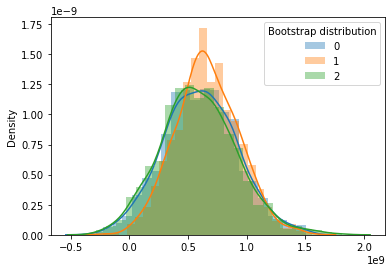

In [39]:
result = defaultdict(list)
random_state = np.random.RandomState(seed=42)

for i, (t_valid, p_valid) in enumerate(zip(target_valid, prediction_valid)):
    values = []
    
    for j in range(BOOTSTRAP_SAMPLES):
        target_subsample = t_valid.sample(WELL_POINTS, replace=True, random_state=random_state)
        subsample = p_valid.loc[target_subsample.index]
        values.append(calculate_revenue(target_subsample, subsample, 200))
        
    values = pd.Series(values)
    lower = (1 - CONFIDENCE_LEVEL) / 2
    upper = (1 + CONFIDENCE_LEVEL) / 2
    result['mean'].append(values.mean())
    result['95_confidence'].append((values.quantile(lower), values.quantile(upper)))
    result['std'].append(values.std())
    result['loss_wells_count'].append((values < 0).sum()/1000)
    sns.distplot(values, label=i)
    plt.legend(title="Bootstrap distribution")

pd.DataFrame(result)    

We recommend choosing region 1, as it has the highest average profit and the narrowest confidence interval.
In addition, region 1 has the lowest risk of loss.

